# Information
$Writer: Junhyuck\ Woo$ <br>
$Std.ID: 20145337$<br>
$Assignment10:\ Multi-label\ classification\ using\ neural\ networks\ with\ a\ regularization$<br>
$Deadline: June\ 4, 2020$
<hr>

# Library

In [1]:
import numpy as np
import re
import nltk
import time
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Data

In [0]:
review_data = load_files(r"/content/drive/My Drive/Spring|2020/Machine_Learning/CAU-MachineLearning/Assignment11/movie_review")
X, y = review_data.data, review_data.target

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [0]:
# Copy for run code
train_data = X_train.T
test_data = X_test.T
train_label = y_train
test_label = y_test

# Neural Network Architecture
* input layer : 784 (+ a bias)
* first hidden layer : 49 (+ a bias)
* output layer : 10

In [0]:
mean = 0
sigma = 0.1
alpha = 0.01
lamda = 0.0005
node_num = [1500, 750, 2]
layer_num = len(node_num)-1
theta_num = 0
train_m = 1400
test_m = 600

network = []
node_t = []
node = []
for i, v in enumerate(node_num[:-1]):
    network.append(np.random.normal(mean, sigma, (node_num[i+1], node_num[i]+1)))
    node_t.append(np.zeros((node_num[i]+1, test_m)))
    node.append(np.zeros((node_num[i]+1, train_m)))
    theta_num = theta_num + (node_num[i+1] * (node_num[i]+1))
node_t.append(np.zeros((node_num[-1], test_m)))
node.append(np.zeros((node_num[-1], train_m)))
node_t = np.array(node_t)
node = np.array(node)

# Sigmoid Function (= activation function)
$\sigma(z) = \frac{1}{1 + \exp(-z)}$<br>
$\sigma(z)' = \sigma(z)(1 - \sigma(z))$

In [0]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_(z_):
    return z_*(1-z_)

# Objective Function
$J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=0}^{9}( - l^{(i)}_k \log( h^{(i)}_k ) - (1 - l^{(i)}_k) \log(1 - h^{(i)}_k) ) + \frac{\lambda}{2 n} \sum_{j=1}^n \theta_j^2$<br>
$\theta = (u, v, w)$

In [0]:
def one_hot(l):
    new_label = np.zeros((2,len(l)))
    for i, v in enumerate(l):
        new_label[v][i] = 1
    return new_label
    
def j_func(network, label, size, layer_num, lamda, theta_num):
    loss_list = -label*np.log(network[layer_num]) - (1 - label)*np.log(1-network[layer_num])
    theta = 0
    for i, v in enumerate(range(layer_num+1)):
        theta = theta + np.sum(network[i]*network[i])
    a = np.sum(loss_list)/size
    b = (lamda*theta)/(2*theta_num)
    loss = a + b
    return (loss)

# Gradient Descent (Back-propagation)
$\theta_{k}^{(t+1)} = \theta_{k}^{(t)} - \alpha \frac{\partial J(\theta^{(t)})}{\partial \theta_{k}},\ for\ all\ k$

In [0]:
def prop(model, nodes, bias, data):

    node = np.concatenate((bias, data), axis=0)
    nodes[0] = node
    
    for i, v in enumerate(node_num[1:]):
        node = np.dot(model[i], nodes[i])
        node = sigmoid(node)
        if v == node_num[-1]:
            nodes[i+1] = node
        else:
            nodes[i+1] = np.concatenate((bias, node), axis=0)

    return nodes

def backprop(model, node, l, size, layer_num, alpha, lamda, theta_num):
    new_model = model

    tmp = (node[layer_num] - l)/size
    new_model[layer_num-1] = (1-alpha*lamda/theta_num)*new_model[layer_num-1] \
                              - alpha*np.dot(tmp, node[layer_num-1].T)

    for i, v in enumerate(range(layer_num-1, 0, -1)):
        tmp = np.dot(new_model[v].T[1:,:], tmp) * sigmoid_(node[v][1:])
        new_model[v-1] = (1-alpha*lamda/theta_num)*new_model[v-1] \
                          - alpha * np.dot(tmp, node[v-1].T)

    return new_model

# Optimization

In [98]:
# Varibales
count = 1
accuracy_history = [[], []]
j = [0, 0]
j_old = 20
j_history = [[], []]
bias_train = np.array([np.ones(train_m)])
bias_test = np.array([np.ones(test_m)])
train_oh_label = one_hot(train_label)
test_oh_label = one_hot(test_label)

# Check the runtime
start = time.time()

while (count <= 500):
#while (abs(j_old - j[0]) > 0.0001):
    # Reset the variables
    accuracy = [0, 0]
    
    # Update the Loss
    j_old = j[0]

    # Train
    # Forward propagation
    node = prop(network, node, bias_train, train_data)
    
    # Train Loss
    j[0] = j_func(node, train_oh_label, train_m, layer_num, lamda, theta_num)

    # Train Accuracy
    h_argmax = []
    for i, v in enumerate(node[layer_num].T):
        h_argmax.append(np.argmax(v))
    accuracy[0] = np.sum(1*np.equal(h_argmax, train_label))

    # Test
    # Forward propagation
    node_t = prop(network, node_t, bias_test, test_data)

    # Test Loss
    j[1] = j_func(node_t, test_oh_label, test_m, layer_num, lamda, theta_num)
    
    # Test Accuracy
    h_t_argmax = []
    for i, v in enumerate(node_t[layer_num].T):
        h_t_argmax.append(np.argmax(v))
    accuracy[1] = np.sum(1*np.equal(h_t_argmax, test_label))
    
    # Back-propagation
    network = backprop(network, node, train_oh_label, train_m, layer_num, alpha, lamda, theta_num)
      
    # Record the history
    accuracy_history[0].append((accuracy[0]*100 / len(h_argmax)))
    j_history[0].append(j[0])
    accuracy_history[1].append(accuracy[1]*100 / len(h_t_argmax))
    j_history[1].append(j[1])

    # Count Iteration
    count = count + 1

    if (count % 50) == 0:
        print("[",count, "] Train: ", accuracy_history[0][-1], j[0], "| Test: ", accuracy_history[1][-1])

runtime = int(time.time() - start)
minute, second = divmod(runtime, 60)
hour, minute = divmod(minute, 60)

[ 50 ] Train:  80.0 1.3248622069750595 | Test:  71.83333333333333
[ 100 ] Train:  80.21428571428571 1.324113661904393 | Test:  71.66666666666667
[ 150 ] Train:  80.21428571428571 1.3233618784631676 | Test:  71.66666666666667
[ 200 ] Train:  80.14285714285714 1.3226068231747008 | Test:  71.66666666666667
[ 250 ] Train:  80.14285714285714 1.3218484627356337 | Test:  72.0
[ 300 ] Train:  80.21428571428571 1.3210867640177304 | Test:  72.33333333333333
[ 350 ] Train:  80.21428571428571 1.3203216940697313 | Test:  72.33333333333333
[ 400 ] Train:  80.42857142857143 1.319553220119268 | Test:  72.16666666666667
[ 450 ] Train:  80.57142857142857 1.318781309574832 | Test:  72.33333333333333
[ 500 ] Train:  80.71428571428571 1.3180059300278046 | Test:  72.33333333333333


# Check the convergence

In [0]:
print("Iteration: ", count)
print("Runtime: ", hour, ":", minute, ":", second)
print("Loss Diff: ", abs(j[0] - j_old))

Iteration:  2121
Runtime:  0 : 5 : 48
Loss Diff:  9.997011949922086e-05


# Check the history for display example

In [0]:
classified_ex = []
misclassified_ex = []
check_list = np.zeros(10)
for i, v in enumerate(h_t_argmax):
    if v==test_label[i]:
        if (len(classified_ex)==10):
            continue
        else:
            if (check_list[v]==0):
                classified_ex.append(i)
                check_list[v] = 1
            else:
                continue
    else:
        if (len(misclassified_ex)==10):
            continue
        else:
            misclassified_ex.append(i)
    if (len(classified_ex)==10) and (len(misclassified_ex)==10):
        break

___
#Result

# 1. Loss Curve

Text(0, 0.5, 'Error')

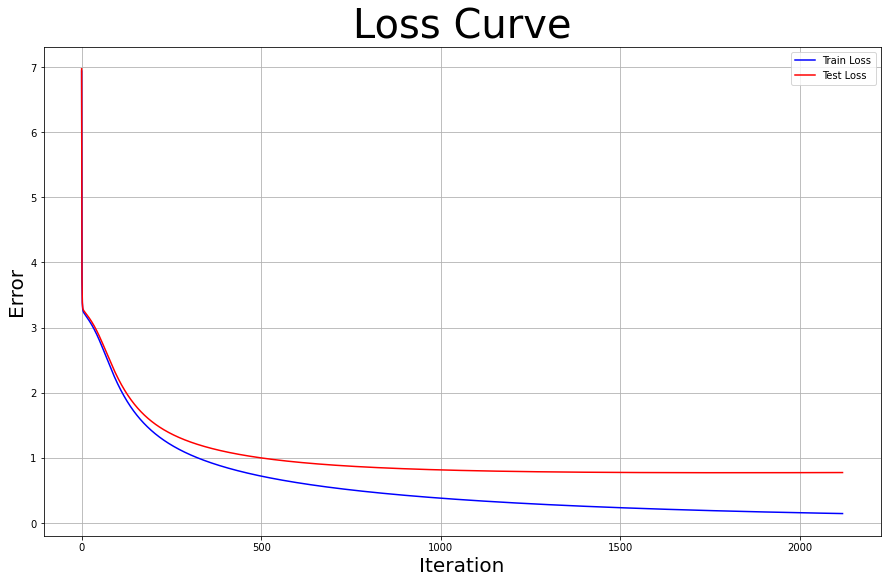

In [0]:
plt.figure(figsize=(15,9))
plt.plot(j_history[0], color='blue', label='Train Loss')
plt.plot(j_history[1], color='red', label='Test Loss')
plt.grid()
plt.legend()
plt.title('Loss Curve', fontsize=40)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Error', fontsize=20)

# 2. Accuravy Curve

Text(0, 0.5, 'Accuracy')

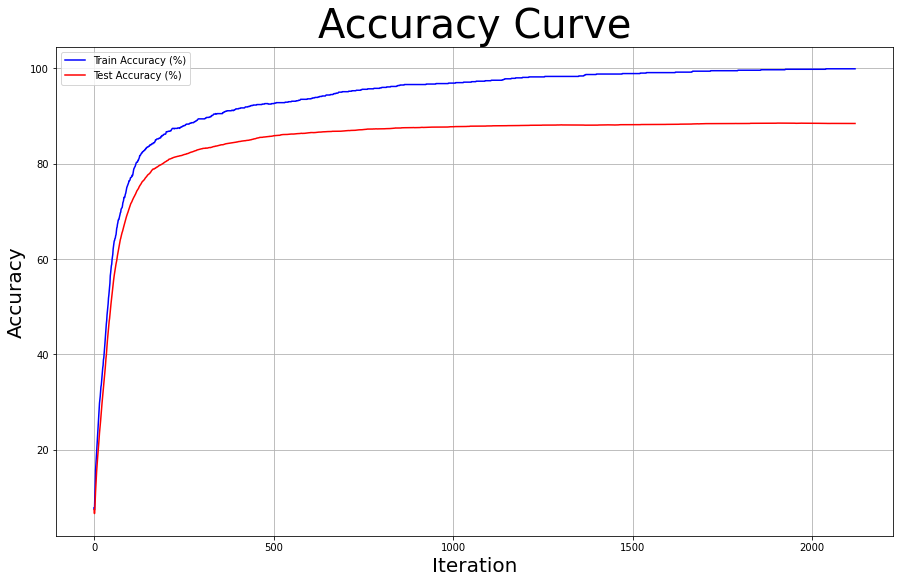

In [0]:
plt.figure(figsize=(15,9))
plt.plot(accuracy_history[0], color='blue', label='Train Accuracy (%)')
plt.plot(accuracy_history[1], color='red', label='Test Accuracy (%)')
plt.grid()
plt.legend()
plt.title('Accuracy Curve', fontsize=40)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

# 3. Accuracy Value

In [0]:
print('Final Accuracy')
print('Train: %lf' %((accuracy[0]*100 / len(h_argmax))))
print('Test: %lf' %((accuracy[1]*100 / len(h_t_argmax))))

Final Accuracy
Train: 99.900000
Test: 88.433333


# 4. Classification Example
## 1. Correctly Classified Testing Image

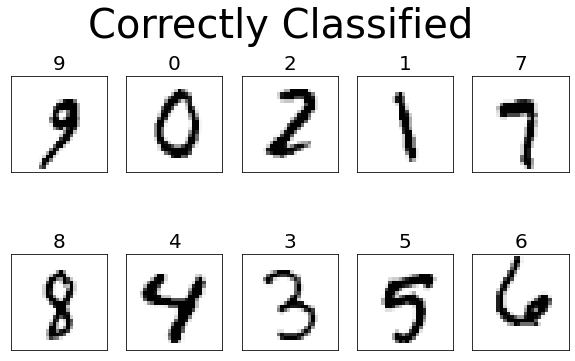

In [0]:
f1 = plt.figure(figsize=(10,6))
plt.suptitle("Correctly Classified", fontsize = 40)
for i in range(10):

    im_vector   = test_image[:, classified_ex[i]]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(2, 5, i+1)
    plt.title(h_t_argmax[classified_ex[i]], fontsize=20)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()

## 2. Misclassified Testing Image

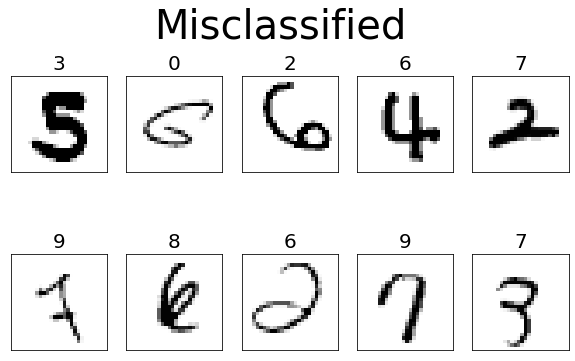

In [0]:
f1 = plt.figure(figsize=(10,6))
plt.suptitle("Misclassified", fontsize = 40)
for i in range(10):

    im_vector   = test_image[:, misclassified_ex[i]]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(2, 5, i+1)
    plt.title(h_t_argmax[misclassified_ex[i]], fontsize=20)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()